# Draw polar plots for all categories

In [ ]:
tf = 2.0
dsi_threshold = 0.5

In [12]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'
    
import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

In [13]:
get_one_category_polar_data_cache = {}

In [14]:
def get_avg_cell_polar_in_experiment(boc, ec_id, exp_id, cells):
    """
    Get the polar data for all cells in this experiment, then average them out to get a single polar data.
    """
    in_category_cells = cells[cells.experiment_container_id == ec_id]
    dg_response_filter = get_dg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
    # Filter out based on new_dsi_cell
    new_col = []
    for index, row in filtered_cells.iterrows():
        polardata_for_this_cell = get_avg_normalized_response(
            boc = boc,
            session_id = exp_id,
            cell_specimen_id = row.cell_specimen_id,
            temporal_frequency = tf)
        if polardata_for_this_cell is None:
            # Put negative value so dsi selector will ignore this guy.
            new_dsi_cell = -1
        else:
            new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
        new_col.append(new_dsi_cell)
    filtered_cells['new_dsi_cell'] = new_col
    filtered_cells = filtered_cells[filtered_cells.new_dsi_cell > dsi_threshold]

    print ("In this experiment, we have", len(in_category_cells),
           "cells, but after filtering, we have", len(filtered_cells), "cells")
    
    thetas = []
    rs = []
    cell_ids = []
    for cell_specimen_id in filtered_cells.cell_specimen_id:
        one_cell_polar_data_dict = get_avg_normalized_response(
            boc=boc,
            session_id=exp_id,
            cell_specimen_id = cell_specimen_id,
            temporal_frequency=tf)
        if one_cell_polar_data_dict is None:
            continue
        theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
        thetas.append(theta)
        rs.append(r)
        cell_ids.append(cell_specimen_id)
    if len(thetas) == 0:
        return None, None
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    return agg_theta, agg_r

In [34]:
def get_one_category_polar_data(boc, targeted_structure, imaging_depth, cre_line):
    cache_key = (targeted_structure, imaging_depth, cre_line)
    if cache_key in get_one_category_polar_data_cache:
        return get_one_category_polar_data_cache[cache_key]
    
    exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
        targeted_structures = [targeted_structure],
        imaging_depths = [imaging_depth],
        cre_lines = [cre_line])
    if len(exps) == 0:
        return None, None, None, None
    print ("There are", len(exps), "experiments for ", targeted_structure, imaging_depth, cre_line)
    
    thetas = []
    rs = []
    for exp in exps:
        e_id = exp['id']
        ec_id = exp['experiment_container_id']
        print("Processing experiment", e_id)
        theta, r = get_avg_cell_polar_in_experiment(boc, ec_id, e_id, cells)
        if theta is None or len(theta) == 0:
            continue
        thetas.append(theta)
        rs.append(r)
        
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    
    if len(thetas) == 0:
        agg_theta, agg_r, thetas, rs= None, None, None, None
    
    get_one_category_polar_data_cache[cache_key] = (agg_theta, agg_r, thetas, rs)
    return get_one_category_polar_data_cache[cache_key]


in method VISp 175 Cux2-CreERT2


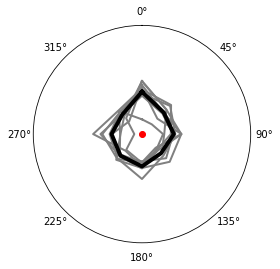

In [31]:
agg_theta, agg_r, thetas, rs = get_one_category_polar_data(boc, 'VISp', 175, 'Cux2-CreERT2')
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
    bold_theta = agg_theta,
    bold_r = agg_r,
    grey_thetas = thetas, 
    grey_rs = rs)

# Plot everything

In [38]:
# See this for the list of valid ones https://pastebin.com/NGzvE0Ky
interesting_categories = [
    ('VISp', 175, 'Cux2-CreERT2'),
    ('VISp', 200, 'Cux2-CreERT2'),
    ('VISp', 205, 'Cux2-CreERT2'),
    ('VISp', 175, 'Emx1-IRES-Cre'),
    ('VISp', 200, 'Emx1-IRES-Cre'),
]

VISp 175 Cux2-CreERT2


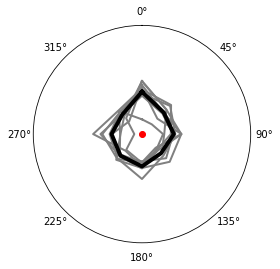

There are 3 experiments for  VISp 175 Emx1-IRES-Cre
Processing experiment 545446482
In this experiment, we have 282 cells, but after filtering, we have 42 cells
Processing experiment 526504941
In this experiment, we have 236 cells, but after filtering, we have 31 cells
Processing experiment 540684467
In this experiment, we have 413 cells, but after filtering, we have 49 cells
VISp 175 Emx1-IRES-Cre


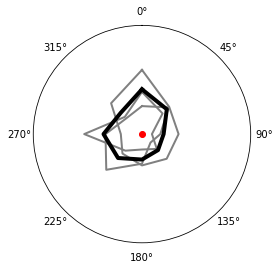

In [39]:
for targeted_structure, imaging_depth, cre_line in interesting_categories:
    agg_theta, agg_r, thetas, rs = get_one_category_polar_data(
        boc,
        targeted_structure,
        imaging_depth,
        cre_line)
    if agg_theta is None:
        continue
    print(targeted_structure, imaging_depth, cre_line)
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot_population(ax=ax,
        bold_theta = agg_theta,
        bold_r = agg_r,
        grey_thetas = thetas, 
        grey_rs = rs)
    plt.show()